In [2]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

In [3]:
def color_grayscale_arr(arr, forground_color, background_color):
    """Converts grayscale image"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if background_color == "black":
        if forground_color == "red":
            arr = np.concatenate([arr,
                              np.zeros((h, w, 2), dtype=dtype)], axis=2)
        elif forground_color == "green":
            arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                              arr,
                              np.zeros((h, w, 1), dtype=dtype)], axis=2)
        elif forground_color == "white":
            arr = np.concatenate([arr, arr, arr], axis=2)
    else:
        if forground_color == "yellow":
            arr = np.concatenate([arr, arr, np.zeros((h, w, 1), dtype=dtype)], axis=2)
        else:
            arr = np.concatenate([np.zeros((h, w, 2), dtype=dtype), arr], axis=2)

        c = [255, 255, 255]
        arr[:, :, 0] = (255 - arr[:, :, 0]) / 255 * c[0]
        arr[:, :, 1] = (255 - arr[:, :, 1]) / 255 * c[1]
        arr[:, :, 2] = (255 - arr[:, :, 2]) / 255 * c[2]
    arr = arr.astype(np.uint8) 


    return arr


class ColoredMNIST(datasets.VisionDataset):

    def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
        super(ColoredMNIST, self).__init__(root, transform=transform,
                                           target_transform=target_transform)

        self.prepare_colored_mnist()
        if env in ['train1', 'train2', 'train3', 'test1', 'test2']:
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
        elif env == 'all_train':
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                                     torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt')) + \
                                     torch.load(os.path.join(self.root, 'ColoredMNIST', 'train3.pt'))
        else:
            raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, train3, test1, test2, and all_train')

    def __getitem__(self, index):
        """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
        img, target = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
        if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'train3.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test1.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test2.pt')):
            print('Colored MNIST dataset already exists')
            return

        print('Preparing Colored MNIST')
        train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

        train1_set = []
        train2_set = []
        train3_set = []
        test1_set, test2_set = [], []
        for idx, (im, label) in enumerate(train_mnist):
            if idx % 10000 == 0:
                print(f'Converting image {idx}/{len(train_mnist)}')
            im_array = np.array(im)
            
            # Assign a binary label y to the image based on the digit
            binary_label = 0 if label < 5 else 1

            # Color the image according to its environment label

            if idx < 10000:
                colored_arr = color_grayscale_arr(im_array, forground_color = "red", background_color = "black")
                train1_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 20000:
                colored_arr = color_grayscale_arr(im_array, forground_color = "green", background_color = "black")
                train2_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 30000:
                colored_arr = color_grayscale_arr(im_array, forground_color = "white", background_color = "black")
                train3_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 45000:
                colored_arr = color_grayscale_arr(im_array, forground_color = "green", background_color = "black")
                test1_set.append((Image.fromarray(colored_arr), binary_label))
            else:
                colored_arr = color_grayscale_arr(im_array, forground_color = "red", background_color = "black")
                test2_set.append((Image.fromarray(colored_arr), binary_label))
                
            # Image.fromarray(colored_arr).save('./data/sample/{}.png'.format(idx))

        if not os.path.exists(colored_mnist_dir):
            os.makedirs(colored_mnist_dir)
        torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
        torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
        torch.save(train3_set, os.path.join(colored_mnist_dir, 'train3.pt'))
        torch.save(test1_set, os.path.join(colored_mnist_dir, 'test1.pt'))
        torch.save(test2_set, os.path.join(colored_mnist_dir, 'test2.pt'))

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print("Loading")
train_dataset1=ColoredMNIST(root='./data', env='train1', transform=transform)
train_dataset2= ColoredMNIST(root='./data', env='train2', transform=transform)
train_dataset3= ColoredMNIST(root='./data', env='train3', transform=transform)
test_dataset1= ColoredMNIST(root='./data', env='test1', transform=transform)
test_dataset2= ColoredMNIST(root='./data', env='test2', transform=transform)

Loading
Colored MNIST dataset already exists


/tmp/ipykernel_2875/4197987548.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')

Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists


/tmp/ipykernel_24370/1836822511.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('./data/ColoredMNIST/test2.pt')


Total samples in train1: 15000
Sample 0: label = 0, image size = (28, 28)


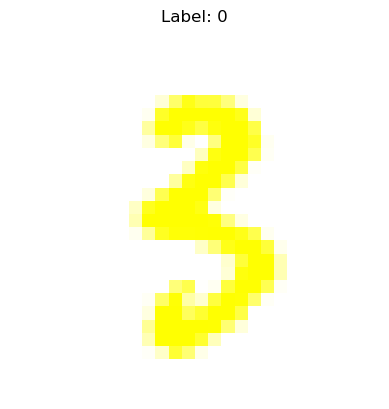

Sample 1: label = 0, image size = (28, 28)


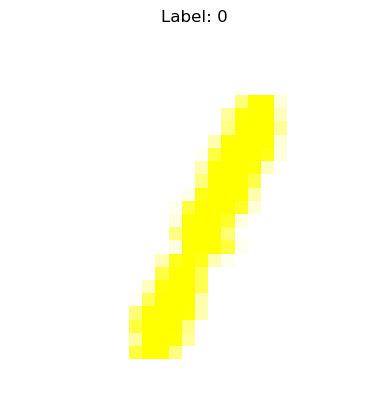

Sample 2: label = 0, image size = (28, 28)


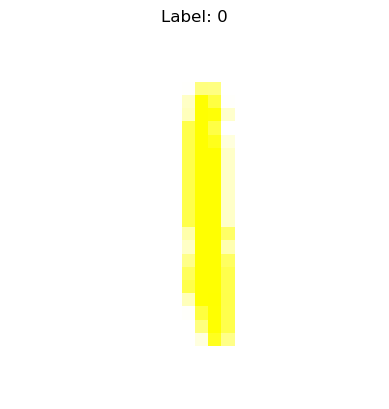

In [8]:
data = torch.load('./data/ColoredMNIST/test2.pt')
print(f'Total samples in train1: {len(data)}')

# 查看前5个样本
for i in range(3):
    img, label = data[i]
    print(f'Sample {i}: label = {label}, image size = {img.size}')
    
    plt.imshow(img)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()